In [5]:
# import opt
import torch
from torch import nn
from torch.nn import Linear
import torch.nn.functional as F
from torch.nn import Module, Parameter

from tqdm.notebook import tqdm
# from utils import *
from torch.optim import Adam

import torch
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from sklearn import metrics
from munkres import Munkres
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

In [2]:
cuda=True
seed=3
alpha_value=0.2
lambda_value=10
gamma_value=1e3
lr=1e-4
n_z=50
epoch=400
show_training_details=False
    
    
    # AE structure parameter from DFCN
ae_n_enc_1=128
ae_n_enc_2=256
ae_n_enc_3=512
ae_n_dec_1=512
ae_n_dec_2=256
ae_n_dec_3=128
    
    # IGAE structure parameter from DFCN
gae_n_enc_1=128
gae_n_enc_2=256
gae_n_enc_3=50
gae_n_dec_1=50
gae_n_dec_2=256
gae_n_dec_3=128
    
    # clustering performance: acc, nmi, ari, f1
acc=0
nmi=0
ari=0
f1=0



Here’s a line-by-line, shape-by-shape unpacking of that `GNNLayer` and what it’s doing.

# What this layer is

It’s a **GCN-style message passing layer**:

1. linearly transform node features,
2. aggregate transformed features from neighbors using the adjacency matrix,
3. (optionally in this code path) aggregate once more to get a two-hop signal.

It returns **one-hop output** and **two-hop output**.

---

# Constructor (`__init__`)

```python
self.in_features = in_features
self.out_features = out_features
if opt.args.name == "dblp":
    self.act = nn.Tanh()
    self.weight = Parameter(torch.FloatTensor(out_features, in_features))
else:
    self.act = nn.Tanh()
    self.weight = Parameter(torch.FloatTensor(in_features, out_features))
torch.nn.init.xavier_uniform_(self.weight)
```

* `in_features`, `out_features`: feature dimensions per node.
* `self.act = nn.Tanh()`: activation function (note: ReLU is more common in GCNs; tanh is perfectly valid but can saturate).
* `self.weight`: learnable projection matrix.

  * **dblp case**: shape `(out_features, in_features)` — chosen to work with `F.linear`, which expects `(out_features, in_features)` and internally uses its transpose.
  * **else**: shape `(in_features, out_features)` — chosen to work with `torch.mm` directly.
* `xavier_uniform_`: good default for tanh/linear layers; helps keep activations in a reasonable range at init.

### Why the odd “dblp” switch?

`F.linear(x, W)` computes `x @ Wᵀ` with `W` stored as `(out, in)`.
`torch.mm(x, W)` computes `x @ W` with `W` stored as `(in, out)`.
The code keeps the stored shape aligned with the chosen multiply API so that the effective product is **always** `(N, in) → (N, out)`.

---

# Forward pass (`forward`)

```python
def forward(self, features, adj, active=False):
    ...
```

**Expected shapes:**

* `features`: `(N, in_features)` — dense float tensor (N = #nodes).
* `adj`: `(N, N)` — **sparse** adjacency (usually symmetric, and typically pre-normalized outside this layer).
* returns:

  * `output`: `(N, out_features)` ≈ **A Z** (one-hop aggregation)
  * `az`: `(N, out_features)` ≈ **A² Z** (two-hop aggregation)

### 1) Linear transform (with optional activation)

```python
if active:
    if opt.args.name == "dblp":
        support = self.act(F.linear(features, self.weight))      # (N, out)
    else:
        support = self.act(torch.mm(features, self.weight))      # (N, out)
else:
    if opt.args.name == "dblp":
        support = F.linear(features, self.weight)                # (N, out)
    else:
        support = torch.mm(features, self.weight)                # (N, out)
```

* `support` is the per-node **projected feature** matrix `Z` with shape `(N, out_features)`.
* `active` flag: when `True`, apply `tanh` **before** neighborhood aggregation; when `False`, skip it (purely linear before aggregation). This lets the authors experiment with **pre-activation** vs **no pre-activation** variants.

### 2) One-hop neighbor aggregation

```python
output = torch.spmm(adj, support)  # (N, N) @ (N, out) = (N, out)
```

* `torch.spmm` = sparse–dense matmul: efficient if `adj` is a `torch.sparse_*` tensor.
* This computes **A Z**: for each node, sum (or weighted sum, if `adj` is normalized) of its neighbors’ transformed features.

### 3) Two-hop aggregation

```python
az = torch.spmm(adj, output)       # (N, N) @ (N, out) = (N, out)
return output, az
```

* Computes **A (A Z) = A² Z**: information aggregated from **two hops** away.
* Naming hint: `az` ≈ “A times (A Z)”.
* Returning both lets downstream code fuse 1-hop and 2-hop signals.

---

# Mathematical summary

Let `X ∈ ℝ^{N×d_in}`, `W ∈ ℝ^{d_in×d_out}` (or `(d_out×d_in)` with `F.linear`), `A ∈ ℝ^{N×N}` (sparse). Define:

* `Z = X W` or `tanh(X W)` depending on `active`.
* `output = A Z` (one hop)
* `az = A output = A² Z` (two hops)

Note: In many GCNs, one uses a **normalized** adjacency `Â = D^{-1/2}(A+I)D^{-1/2}` with self-loops. This layer doesn’t normalize internally, so **whoever builds `adj` must handle normalization/self-loops** if desired.

---

# Practical notes & pitfalls

* **Adjacency type**: `torch.spmm` requires a **sparse** adjacency. If you pass a dense tensor, use `torch.mm` instead.
* **Normalization & self-loops**: If `adj` isn’t normalized / lacks self-loops, the scale and semantics of aggregation will differ (can cause exploding/vanishing or over-smoothing). Preprocess `adj` appropriately.
* **Bias**: no bias term is used; if you need it, you’d add `bias` to the linear transform.
* **Activation placement**: Only applied before aggregation when `active=True`. There’s no post-aggregation nonlinearity in this layer—some architectures add another `act` after `output`.
* **Tanh choice**: Tanh can saturate; ReLU/LeakyReLU/ELU may train faster depending on the task.
* **Return values**: Returning both `output` and `az` suggests the enclosing model (DFCN) may **fuse 1-hop and 2-hop** features for richer locality.


Great — let’s break this `Readout` class down.

---

## High-level idea

It’s a **readout function** that takes node embeddings `Z` (shape `(N, d)`) and compresses them into a **single graph-level (or cluster-level) embedding**.

It does this by:

1. Splitting the `N` nodes into `K` contiguous groups,
2. Averaging the embeddings inside each group,
3. Concatenating those group-level averages into a single vector.

So it turns node-level features into a fixed-size representation of length `K * d`.

---

## Step-by-step

### Constructor

```python
def __init__(self, K):
    self.K = K
```

* `K` = number of clusters / groups to partition the nodes into.
* Controls the “resolution” of the readout: higher `K` = more groups preserved.

---

### Forward

```python
def forward(self, Z):
    n_node = Z.shape[0]     # number of nodes N
    step = n_node // self.K # how many nodes per group (integer division)
```

* `Z` is `(N, d)` (N nodes, each with d-dim embedding).
* `step` is the group size, i.e. how many nodes per cluster.

---

### Grouping & averaging

```python
Z_tilde = []
for i in range(0, n_node, step):
    if n_node - i < 2 * step:
        Z_tilde.append(torch.mean(Z[i:n_node], dim=0))
        break
    else:
        Z_tilde.append(torch.mean(Z[i:i + step], dim=0))
```

* Loop slices `Z` into contiguous chunks of length `step`.
* For each chunk:

  * If we’re near the end and fewer than `2*step` nodes remain, it just averages *all remaining nodes* to avoid leaving a tiny last group.
  * Otherwise, it averages exactly `step` nodes.
* Each average is a vector of shape `(d,)`.

So `Z_tilde` becomes a list of about `K` vectors, each `(d,)`.

---

### Concatenate

```python
Z_tilde = torch.cat(Z_tilde, dim=0)
return Z_tilde.view(1, -1)
```

* Concatenates all group-average vectors into a long 1-D vector of length `K*d` (or close, depending on rounding).
* `.view(1, -1)` reshapes it to `(1, K*d)` so the output is a **single row vector**.

---

## Example

Say:

* `N = 100` nodes,
* embedding size `d = 64`,
* `K = 10`.

Then:

* `step = 100 // 10 = 10`.
* Splits nodes into \~10 groups of size 10.
* Averages each group → 10 vectors of shape `(64,)`.
* Concatenates → `(640,)`.
* Reshapes → `(1, 640)`.

So the graph’s embedding is a single row vector of length `K * d`.

---

## Interpretation

* **Why do this?** It creates a **fixed-length representation** regardless of the number of nodes in the input graph.
* Instead of pooling all nodes into one vector (like global mean pooling), it keeps some *locality/partition structure* by using `K` groups.
* Essentially: *"structured graph readout via grouped averaging."*

---

⚡ Quick summary:
This `Readout` takes all node embeddings `Z (N, d)`, splits the nodes into `K` contiguous chunks, averages each chunk, concatenates those averages, and outputs a single `(1, K*d)` embedding — a fixed-size vector summarizing the whole graph.

---

Do you want me to also show how this compares to standard **global mean pooling** in GNNs, and why this grouped strategy might be used in the DFCN model?


Awesome—here’s a clear, shape-aware walkthrough of what this **Dual Correlation Reduction Network (DCRN)** is doing and how data flows through it.

# What DCRN is (big picture)

DCRN fuses two kinds of node representations—

1. a **feature-only Autoencoder (AE)** path, and
2. a **graph-structure-aware Improved Graph Autoencoder (IGAE)** path—
   then **reduces correlations** and **refines** them through graph-based smoothing and similarity propagation. It also keeps **cluster centers** and computes **soft assignments** (like DEC) for clustering. A readout block summarizes node embeddings into cluster-level vectors.

---

# Modules & learnable parameters

## 1) Autoencoder (AE)

```python
self.ae = AE(..., n_input=opt.args.n_input, n_z=opt.args.n_z)
```

* Encodes each node’s feature vector (dim `n_input`) into a latent vector of dim `n_z`, then can decode back to features.
* Shape-wise: if `X` is `(N, n_input)`, `AE.encoder(X)` → `Z_ae` of shape `(N, n_z)`; `AE.decoder(Z)` → `X_hat` `(N, n_input)`.

## 2) Improved Graph Autoencoder (IGAE)

```python
self.gae = IGAE(..., n_input=opt.args.n_input)
```

* Encodes node features **with adjacency** to produce a **graph-aware** embedding of fixed size **20** (per the args).
* The encoder returns:

  * `Z_igae` `(N, 20)` — node embeddings,
  * `A_igae` `(N, N)` — a learned/denoised adjacency (or similarity) from IGAE,
  * `AZ` — a list of propagated embeddings at intermediate layers (A·Z, A²·Z, …),
  * `Z_list` — a list of intermediate embeddings before propagation.
* The decoder reconstructs both node embeddings and graph structure.

## 3) Fusion parameters (from DFCN)

```python
self.a = Parameter( ... shape (n_node, 20) filled with 0.5 ... )
self.b = Parameter( ... shape (n_node, 20) filled with 0.5 ... )
self.alpha = Parameter(torch.zeros(1))
```

* **`a` and `b`**: per-node, per-dimension gates that **blend** AE vs IGAE embeddings:

  * `Z_i = a ⊙ Z_ae + b ⊙ Z_igae`.
  * Shapes must match: this implies **`opt.args.n_z == 20`** so that `Z_ae` and `Z_igae` have the same last dimension (20).
* **`alpha`**: scalar mixing weight to combine a graph-similarity propagated embedding with a directly smoothed one (see the fusion block below).

## 4) Cluster centers & Readout

```python
self.cluster_centers = Parameter(torch.Tensor(n_clusters, 20))
self.R = Readout(K=n_clusters)
```

* `cluster_centers`: the learnable centroids (one per cluster) in the **20-dim** space used for **soft assignments**.
* `Readout(K)`: takes node embeddings `(N, d)` and returns a **single** row vector `(1, K*d)` by splitting nodes into `K` groups and averaging per group (you already examined this).

---

# Soft assignment (DEC-style)

```python
def q_distribute(self, Z, Z_ae, Z_igae):
    q = 1 / (1 + sum((Z - c_k)^2))       # Student-t kernel vs each center
    q = q / row_sums(q)                   # normalize per node
    # same for q_ae and q_igae
    return [q, q_ae, q_igae]
```

* For each node and each cluster center, compute a **Student-t** similarity (no explicit degree-of-freedom term; effectively ν=1).
* Row-normalize to get probabilities.
* Do it for the **fusion** embedding `Z`, and **also** for the individual streams `Z_ae` and `Z_igae`.
* Output: three `(N, n_clusters)` matrices.

---

# Forward pass (data flow)

Inputs:

* `X_tilde1, X_tilde2`: two **views** of node features, each `(N, n_input)` (e.g., two augmentations or two modalities).
* `Am, Ad`: two adjacency matrices `(N, N)` (e.g., different graphs/views: “m” vs “d”). Typically sparse or normalized.

### 1) Encode each view with AE

```python
Z_ae1 = AE.encoder(X_tilde1)   # (N, 20)
Z_ae2 = AE.encoder(X_tilde2)   # (N, 20)
```

> assumes `n_z == 20` so it can fuse with IGAE downstream.

### 2) Encode each view with IGAE

```python
Z_igae1, A_igae1, AZ_1, Z_1 = IGAE.encoder(X_tilde1, Am)  # (N,20), (N,N), [layerwise], [layerwise]
Z_igae2, A_igae2, AZ_2, Z_2 = IGAE.encoder(X_tilde2, Ad)
```

* You get graph-aware embeddings for each view and ancillary layerwise signals.

### 3) Cluster-level readouts (per view, per stream)

```python
Z_tilde_ae1   = R(Z_ae1)    # (1, n_clusters * 20)
Z_tilde_ae2   = R(Z_ae2)
Z_tilde_igae1 = R(Z_igae1)
Z_tilde_igae2 = R(Z_igae2)
```

* These summarize node embeddings into fixed-size vectors per graph (or per batch item).

### 4) Average the two views within each stream

```python
Z_ae   = (Z_ae1   + Z_ae2) / 2     # (N, 20)
Z_igae = (Z_igae1 + Z_igae2) / 2   # (N, 20)
```

### 5) **Fusion block** (DFCN style)

```python
Z_i = a ⊙ Z_ae + b ⊙ Z_igae        # (N, 20)  elementwise blend, per-node, per-dim gates
Z_l = Am · Z_i                     # (N, 20)  one-hop smoothing by Am (graph propagation)
S   = softmax( Z_l · Z_lᵀ, dim=1 ) # (N, N)   node–node similarity with row-wise softmax
Z_g = S · Z_l                      # (N, 20)  propagate via learned similarities
Z   = alpha * Z_g + Z_l            # (N, 20)  residual mix (learned scalar alpha)
```

Intuition:

* `Z_i`: blend feature-only vs graph-aware.
* `Z_l`: smooth over neighbors via `Am`.
* `S`: build a **data-driven affinity** from inner products of smoothed embeddings, normalize rows.
* `Z_g`: propagate through this learned affinity.
* `Z`: residual mixing between structural smoothing (`Z_l`) and similarity propagation (`Z_g`) controlled by `alpha`.

### 6) Reconstructions

**AE decoding (feature reconstruction)**

```python
X_hat = AE.decoder(Z)              # (N, n_input)
```

* Reconstructs node features from fused embedding → AE loss term.

**IGAE decoding (graph/embedding reconstruction)**

```python
Z_hat, Z_adj_hat, AZ_de, Z_de = IGAE.decoder(Z, Am)
sim = (A_igae1 + A_igae2) / 2      # averaged structure from both views
A_hat = sim + Z_adj_hat            # combine encoder-learned sim with decoder’s adj recon
```

* `Z_adj_hat` is a reconstructed adjacency (or similarity) from the decoder path.
* `A_hat` mixes the encoder-side learned structure (`sim`) and decoder reconstruction.

### 7) Package stream outputs

```python
Z_ae_all  = [Z_ae1, Z_ae2, Z_tilde_ae1,  Z_tilde_ae2]   # node-level & readout for AE stream
Z_gae_all = [Z_igae1, Z_igae2, Z_tilde_igae1, Z_tilde_igae2]
```

### 8) Soft assignments (for clustering)

```python
Q = q_distribute(Z, Z_ae, Z_igae)  # [q, q_ae, q_igae], each (N, n_clusters)
```

### 9) Layerwise propagated signals for supervision/aux

```python
AZ_en = [(AZ_1[i] + AZ_2[i]) / 2 for i in range(len(AZ_1))]  # encoder-level propagated
Z_en  = [(Z_1[i]  + Z_2[i])  / 2 for i in range(len(Z_1))]   # encoder-level embeddings
AZ_all = [AZ_en, AZ_de]  # [encoder side list, decoder side list]
Z_all  = [Z_en,  Z_de]   # same for embeddings
```

* These collections enable multi-level losses (e.g., consistency between encoder/decoder layers, correlation penalties, etc.).

---

# Returns (in order)

```python
return (
  X_hat,          # (N, n_input): AE reconstruction from fused Z
  Z_hat,          # (N, 20):     IGAE-decoder embedding reconstruction
  A_hat,          # (N, N):      combined reconstructed adjacency/similarity
  sim,            # (N, N):      averaged encoder-learned structure from both views
  Z_ae_all,       # [Z_ae1, Z_ae2, readout_ae1, readout_ae2]
  Z_gae_all,      # [Z_igae1, Z_igae2, readout_igae1, readout_igae2]
  Q,              # [q, q_ae, q_igae] soft assignments (N, n_clusters each)
  Z,              # (N, 20):     final fused node embeddings
  AZ_all,         # [[AZ_en_layers...], AZ_de_layers...] propagated embeddings
  Z_all           # [[Z_en_layers...],  Z_de_layers... ]
)
```

---

# Why these pieces exist (training/use)

* **AE loss** on `X_hat` encourages preserving feature information.
* **IGAE losses** on `Z_hat`, `A_hat` encourage structural fidelity and robust graph modeling.
* **Fusion & correlation reduction**: elementwise gates (`a`, `b`), smoothing (`Am`), and similarity propagation (`S`) reduce redundancy and align views.
* **Clustering**: `cluster_centers` + `Q` enable DEC-like training (KL to a sharpened target `P`) to produce clusterable embeddings.
* **Readouts** provide graph-level/cluster-level summaries that can be used for auxiliary objectives or downstream tasks.

---

# Key assumptions & gotchas

* **Dimensionality match**: Because `a`/`b` are `(n_node, 20)`, you need `opt.args.n_z == 20` so `Z_ae` and `Z_igae` can be blended elementwise.
* **Adjacency normalization**: Good practice to pass **normalized** `Am`, `Ad` (e.g., $\hat A$) for stable propagation.
* **`alpha` init**: starts at 0 → the model initially trusts `Z_l` more than `Z_g`, and can learn to upweight `Z_g`.
* **Two views**: The design assumes two complementary inputs (feature views and/or graph views) that benefit from co-regularization.

If you want, I can sketch typical **loss terms** this architecture would pair with (AE recon, IGAE recon, KL to target distribution for clustering, correlation penalties between views, etc.) and how you’d wire them up to train end-to-end.


In [3]:
# AE encoder from DFCN
class AE_encoder(nn.Module):
    def __init__(self, ae_n_enc_1, ae_n_enc_2, ae_n_enc_3, n_input, n_z):
        super(AE_encoder, self).__init__()
        self.enc_1 = Linear(n_input, ae_n_enc_1)
        self.enc_2 = Linear(ae_n_enc_1, ae_n_enc_2)
        self.enc_3 = Linear(ae_n_enc_2, ae_n_enc_3)
        self.z_layer = Linear(ae_n_enc_3, n_z)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        z = self.act(self.enc_1(x))
        z = self.act(self.enc_2(z))
        z = self.act(self.enc_3(z))
        z_ae = self.z_layer(z)
        return z_ae


# AE decoder from DFCN
class AE_decoder(nn.Module):
    def __init__(self, ae_n_dec_1, ae_n_dec_2, ae_n_dec_3, n_input, n_z):
        super(AE_decoder, self).__init__()

        self.dec_1 = Linear(n_z, ae_n_dec_1)
        self.dec_2 = Linear(ae_n_dec_1, ae_n_dec_2)
        self.dec_3 = Linear(ae_n_dec_2, ae_n_dec_3)
        self.x_bar_layer = Linear(ae_n_dec_3, n_input)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, z_ae):
        z = self.act(self.dec_1(z_ae))
        z = self.act(self.dec_2(z))
        z = self.act(self.dec_3(z))
        x_hat = self.x_bar_layer(z)
        return x_hat


# Auto Encoder from DFCN
class AE(nn.Module):
    def __init__(self, ae_n_enc_1, ae_n_enc_2, ae_n_enc_3, ae_n_dec_1, ae_n_dec_2, ae_n_dec_3, n_input, n_z):
        super(AE, self).__init__()

        self.encoder = AE_encoder(
            ae_n_enc_1=ae_n_enc_1,
            ae_n_enc_2=ae_n_enc_2,
            ae_n_enc_3=ae_n_enc_3,
            n_input=n_input,
            n_z=n_z)

        self.decoder = AE_decoder(
            ae_n_dec_1=ae_n_dec_1,
            ae_n_dec_2=ae_n_dec_2,
            ae_n_dec_3=ae_n_dec_3,
            n_input=n_input,
            n_z=n_z)


# GNNLayer from DFCN
class GNNLayer(Module):
    def __init__(self, in_features, out_features,dataset_name:str="amac"):
        super(GNNLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dataset_name = dataset_name
        if self.dataset_name == "dblp":
            self.act = nn.Tanh()
            self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        else:
            self.act = nn.Tanh()
            self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        torch.nn.init.xavier_uniform_(self.weight)

    def forward(self, features, adj, active=False):
        if active:
            if self.dataset_name == "dblp":
                support = self.act(F.linear(features, self.weight))
            else:
                support = self.act(torch.mm(features, self.weight))
        else:
            if self.dataset_name == "dblp":
                support = F.linear(features, self.weight)
            else:
                support = torch.mm(features, self.weight)
        output = torch.spmm(adj, support)
        az = torch.spmm(adj, output)
        return output, az


# IGAE encoder from DFCN
class IGAE_encoder(nn.Module):
    def __init__(self, gae_n_enc_1, gae_n_enc_2, gae_n_enc_3, n_input):
        super(IGAE_encoder, self).__init__()
        self.gnn_1 = GNNLayer(n_input, gae_n_enc_1)
        self.gnn_2 = GNNLayer(gae_n_enc_1, gae_n_enc_2)
        self.gnn_3 = GNNLayer(gae_n_enc_2, gae_n_enc_3)
        self.s = nn.Sigmoid()

    def forward(self, x, adj):
        z_1, az_1 = self.gnn_1(x, adj, active=True)
        z_2, az_2 = self.gnn_2(z_1, adj, active=True)
        z_igae, az_3 = self.gnn_3(z_2, adj, active=False)
        z_igae_adj = self.s(torch.mm(z_igae, z_igae.t()))
        return z_igae, z_igae_adj, [az_1, az_2, az_3], [z_1, z_2, z_igae]


# IGAE decoder from DFCN
class IGAE_decoder(nn.Module):
    def __init__(self, gae_n_dec_1, gae_n_dec_2, gae_n_dec_3, n_input):
        super(IGAE_decoder, self).__init__()
        self.gnn_4 = GNNLayer(gae_n_dec_1, gae_n_dec_2)
        self.gnn_5 = GNNLayer(gae_n_dec_2, gae_n_dec_3)
        self.gnn_6 = GNNLayer(gae_n_dec_3, n_input)
        self.s = nn.Sigmoid()

    def forward(self, z_igae, adj):
        z_1, az_1 = self.gnn_4(z_igae, adj, active=True)
        z_2, az_2 = self.gnn_5(z_1, adj, active=True)
        z_hat, az_3 = self.gnn_6(z_2, adj, active=True)
        z_hat_adj = self.s(torch.mm(z_hat, z_hat.t()))
        return z_hat, z_hat_adj, [az_1, az_2, az_3], [z_1, z_2, z_hat]


# Improved Graph Auto Encoder from DFCN
class IGAE(nn.Module):
    def __init__(self, gae_n_enc_1, gae_n_enc_2, gae_n_enc_3, gae_n_dec_1, gae_n_dec_2, gae_n_dec_3, n_input):
        super(IGAE, self).__init__()
        # IGAE encoder
        self.encoder = IGAE_encoder(
            gae_n_enc_1=gae_n_enc_1,
            gae_n_enc_2=gae_n_enc_2,
            gae_n_enc_3=gae_n_enc_3,
            n_input=n_input)

        # IGAE decoder
        self.decoder = IGAE_decoder(
            gae_n_dec_1=gae_n_dec_1,
            gae_n_dec_2=gae_n_dec_2,
            gae_n_dec_3=gae_n_dec_3,
            n_input=n_input)


# readout function
class Readout(nn.Module):
    def __init__(self, K):
        super(Readout, self).__init__()
        self.K = K

    def forward(self, Z):
        # calculate cluster-level embedding
        Z_tilde = []

        # step1: split the nodes into K groups
        # step2: average the node embedding in each group
        n_node = Z.shape[0]
        step = n_node // self.K
        for i in range(0, n_node, step):
            if n_node - i < 2 * step:
                Z_tilde.append(torch.mean(Z[i:n_node], dim=0))
                break
            else:
                Z_tilde.append(torch.mean(Z[i:i + step], dim=0))

        # the cluster-level embedding
        Z_tilde = torch.cat(Z_tilde, dim=0)
        return Z_tilde.view(1, -1)


# Dual Correlation Reduction Network
class DCRN(nn.Module):
    def __init__(self, n_node=None):
        super(DCRN, self).__init__()

        # Auto Encoder
        self.ae = AE(
            ae_n_enc_1=ae_n_enc_1,
            ae_n_enc_2=ae_n_enc_2,
            ae_n_enc_3=ae_n_enc_3,
            ae_n_dec_1=ae_n_dec_1,
            ae_n_dec_2=ae_n_dec_2,
            ae_n_dec_3=ae_n_dec_3,
            n_input=n_input,
            n_z=n_z)

        # Improved Graph Auto Encoder From DFCN
        self.gae = IGAE(
            gae_n_enc_1=gae_n_enc_1,
            gae_n_enc_2=gae_n_enc_2,
            gae_n_enc_3=gae_n_enc_3,
            gae_n_dec_1=gae_n_dec_1,
            gae_n_dec_2=gae_n_dec_2,
            gae_n_dec_3=gae_n_dec_3,
            n_input=n_input)

        # fusion parameter from DFCN
        self.a = Parameter(nn.init.constant_(torch.zeros(n_node, n_z), 0.5), requires_grad=True)
        self.b = Parameter(nn.init.constant_(torch.zeros(n_node, n_z), 0.5), requires_grad=True)
        self.alpha = Parameter(torch.zeros(1))

        # cluster layer (clustering assignment matrix)
        self.cluster_centers = Parameter(torch.Tensor(n_clusters, n_z), requires_grad=True)

        # readout function
        self.R = Readout(K=n_clusters)

    # calculate the soft assignment distribution Q
    def q_distribute(self, Z, Z_ae, Z_igae):
        """
        calculate the soft assignment distribution based on the embedding and the cluster centers
        Args:
            Z: fusion node embedding
            Z_ae: node embedding encoded by AE
            Z_igae: node embedding encoded by IGAE
        Returns:
            the soft assignment distribution Q
        """
        q = 1.0 / (1.0 + torch.sum(torch.pow(Z.unsqueeze(1) - self.cluster_centers, 2), 2))
        q = (q.t() / torch.sum(q, 1)).t()

        q_ae = 1.0 / (1.0 + torch.sum(torch.pow(Z_ae.unsqueeze(1) - self.cluster_centers, 2), 2))
        q_ae = (q_ae.t() / torch.sum(q_ae, 1)).t()

        q_igae = 1.0 / (1.0 + torch.sum(torch.pow(Z_igae.unsqueeze(1) - self.cluster_centers, 2), 2))
        q_igae = (q_igae.t() / torch.sum(q_igae, 1)).t()

        return [q, q_ae, q_igae]

    def forward(self, X_tilde1, Am, X_tilde2, Ad):
        # node embedding encoded by AE
        Z_ae1 = self.ae.encoder(X_tilde1)
        Z_ae2 = self.ae.encoder(X_tilde2)

        # node embedding encoded by IGAE
        Z_igae1, A_igae1, AZ_1, Z_1 = self.gae.encoder(X_tilde1, Am)
        Z_igae2, A_igae2, AZ_2, Z_2 = self.gae.encoder(X_tilde2, Ad)

        # cluster-level embedding calculated by readout function
        Z_tilde_ae1 = self.R(Z_ae1)
        Z_tilde_ae2 = self.R(Z_ae2)
        Z_tilde_igae1 = self.R(Z_igae1)
        Z_tilde_igae2 = self.R(Z_igae2)

        # linear combination of view 1 and view 2
        Z_ae = (Z_ae1 + Z_ae2) / 2
        Z_igae = (Z_igae1 + Z_igae2) / 2

        # node embedding fusion from DFCN
        Z_i = self.a * Z_ae + self.b * Z_igae
        Z_l = torch.spmm(Am, Z_i)
        S = torch.mm(Z_l, Z_l.t())
        S = F.softmax(S, dim=1)
        Z_g = torch.mm(S, Z_l)
        Z = self.alpha * Z_g + Z_l

        # AE decoding
        X_hat = self.ae.decoder(Z)

        # IGAE decoding
        Z_hat, Z_adj_hat, AZ_de, Z_de = self.gae.decoder(Z, Am)
        sim = (A_igae1 + A_igae2) / 2
        A_hat = sim + Z_adj_hat

        # node embedding and cluster-level embedding
        Z_ae_all = [Z_ae1, Z_ae2, Z_tilde_ae1, Z_tilde_ae2]
        Z_gae_all = [Z_igae1, Z_igae2, Z_tilde_igae1, Z_tilde_igae2]

        # the soft assignment distribution Q
        Q = self.q_distribute(Z, Z_ae, Z_igae)

        # propagated embedding AZ_all and embedding Z_all
        AZ_en = []
        Z_en = []
        for i in range(len(AZ_1)):
            AZ_en.append((AZ_1[i]+AZ_2[i])/2)
            Z_en.append((Z_1[i]+Z_2[i])/2)
        AZ_all = [AZ_en, AZ_de]
        Z_all = [Z_en, Z_de]

        return X_hat, Z_hat, A_hat, sim, Z_ae_all, Z_gae_all, Q, Z, AZ_all, Z_all


In [4]:
# if opt.args.name == 'acm':
#         opt.args.n_clusters = 3
#         opt.args.n_input = 100
#         opt.args.alpha_value = 0.2
#         opt.args.lambda_value = 10
#         opt.args.gamma_value = 1e3
#         opt.args.lr = 5e-5

#     elif opt.args.name == 'dblp':
#         opt.args.n_clusters = 4
#         opt.args.n_input = 50
#         opt.args.alpha_value = 0.2
#         opt.args.lambda_value = 10
#         opt.args.gamma_value = 1e3
#         opt.args.lr = 1e-4

#     elif opt.args.name == 'cite':
#         opt.args.n_clusters = 6
#         opt.args.n_input = 100
#         opt.args.alpha_value = 0.2
#         opt.args.lambda_value = 10
#         opt.args.gamma_value = 1e3
#         opt.args.lr = 1e-5

#     elif opt.args.name == 'amap':
#         opt.args.n_clusters = 8
#         opt.args.n_input = 100
#         opt.args.alpha_value = 0.2
#         opt.args.lambda_value = 10
#         opt.args.gamma_value = 1e3
#         opt.args.lr = 1e-3

#     elif opt.args.name == 'wiki':
#         opt.args.n_clusters = 17
#         opt.args.n_input = 100
#         opt.args.alpha_value = 0.2
#         opt.args.lambda_value = 10
#         opt.args.gamma_value = 1e3
#         opt.args.lr = 1e-3

    # elif opt.args.name == 'amac':
    #     opt.args.n_clusters = 10
    #     opt.args.n_input = 100
    #     opt.args.alpha_value = 0.2
    #     opt.args.lambda_value = 10
    #     opt.args.gamma_value = 1e3
    #     opt.args.lr = 1e-3

device = "cpu"


def setup_seed(seed):
    """
    setup random seed to fix the result
    Args:
        seed: random seed
    Returns: None
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
setup_seed(32)

def numpy_to_torch(a, sparse=False):
    """
    numpy array to torch tensor
    :param a: the numpy array
    :param sparse: is sparse tensor or not
    :return: torch tensor
    """
    if sparse:
        a = torch.sparse.Tensor(a)
        a = a.to_sparse()
    else:
        a = torch.FloatTensor(a)
    return a


def torch_to_numpy(t):
    """
    torch tensor to numpy array
    :param t: the torch tensor
    :return: numpy array
    """
    return t.numpy()


def load_graph_data(dataset_name, show_details=True):
    """
    load graph data
    :param dataset_name: the name of the dataset
    :param show_details: if show the details of dataset
    - dataset name
    - features' shape
    - labels' shape
    - adj shape
    - edge num
    - category num
    - category distribution
    :return: the features, labels and adj
    """
    load_path = "./datasets/existing_data/" + dataset_name + "/" + dataset_name
    feat = np.load(load_path+"_feat.npy", allow_pickle=True)
    label = np.load(load_path+"_label.npy", allow_pickle=True)
    adj = np.load(load_path+"_adj.npy", allow_pickle=True)
    if show_details:
        print("++++++++++++++++++++++++++++++")
        print("---details of graph dataset---")
        print("++++++++++++++++++++++++++++++")
        print("dataset name:   ", dataset_name)
        print("feature shape:  ", feat.shape)
        print("label shape:    ", label.shape)
        print("adj shape:      ", adj.shape)
        print("undirected edge num:   ", int(np.nonzero(adj)[0].shape[0]/2))
        print("category num:          ", max(label)-min(label)+1)
        print("category distribution: ")
        for i in range(max(label)+1):
            print("label", i, end=":")
            print(len(label[np.where(label == i)]))
        print("++++++++++++++++++++++++++++++")
    # feat_pca = feat[:,:-1]
    # X pre-processing
    pca = PCA(n_components=n_input)
    result = pca.fit_transform(feat)
    # result = np.column_stack((feat_pca, feat[:,-1]))
    return result, label, adj


def normalize_adj(adj, self_loop=True, symmetry=False):
    """
    normalize the adj matrix
    :param adj: input adj matrix
    :param self_loop: if add the self loop or not
    :param symmetry: symmetry normalize or not
    :return: the normalized adj matrix
    """
    # add the self_loop
    if self_loop:
        adj_tmp = adj + np.eye(adj.shape[0])
    else:
        adj_tmp = adj

    # calculate degree matrix and it's inverse matrix
    d = np.diag(adj_tmp.sum(0))
    d_inv = np.linalg.inv(d)

    # symmetry normalize: D^{-0.5} A D^{-0.5}
    if symmetry:
        sqrt_d_inv = np.sqrt(d_inv)
        norm_adj = np.matmul(np.matmul(sqrt_d_inv, adj_tmp), adj_tmp)

    # non-symmetry normalize: D^{-1} A
    else:
        norm_adj = np.matmul(d_inv, adj_tmp)

    return norm_adj


def gaussian_noised_feature(X):
    """
    add gaussian noise to the attribute matrix X
    Args:
        X: the attribute matrix
    Returns: the noised attribute matrix X_tilde
    """
    N_1 = torch.Tensor(np.random.normal(1, 0.1, X.shape)).to(device)
    N_2 = torch.Tensor(np.random.normal(1, 0.1, X.shape)).to(device)
    X_tilde1 = X * N_1
    X_tilde2 = X * N_2
    return X_tilde1, X_tilde2


def diffusion_adj(adj, mode="ppr", transport_rate=0.2):
    """
    graph diffusion
    :param adj: input adj matrix
    :param mode: the mode of graph diffusion
    :param transport_rate: the transport rate
    - personalized page rank
    -
    :return: the graph diffusion
    """
    # add the self_loop
    adj_tmp = adj + np.eye(adj.shape[0])

    # calculate degree matrix and it's inverse matrix
    d = np.diag(adj_tmp.sum(0))
    d_inv = np.linalg.inv(d)
    sqrt_d_inv = np.sqrt(d_inv)

    # calculate norm adj
    norm_adj = np.matmul(np.matmul(sqrt_d_inv, adj_tmp), sqrt_d_inv)

    # calculate graph diffusion
    if mode == "ppr":
        diff_adj = transport_rate * np.linalg.inv((np.eye(d.shape[0]) - (1 - transport_rate) * norm_adj))

    return diff_adj


def remove_edge(A, similarity, remove_rate=0.1):
    """
    remove edge based on embedding similarity
    Args:
        A: the origin adjacency matrix
        similarity: cosine similarity matrix of embedding
        remove_rate: the rate of removing linkage relation
    Returns:
        Am: edge-masked adjacency matrix
    """
    # remove edges based on cosine similarity of embedding
    n_node = A.shape[0]
    for i in range(n_node):
        A[i, torch.argsort(similarity[i].cpu())[:int(round(remove_rate * n_node))]] = 0

    # normalize adj
    Am = normalize_adj(A, self_loop=True, symmetry=False)
    Am = numpy_to_torch(Am).to(device)
    return Am


def load_pretrain_parameter(model):
    """
    load pretrained parameters
    Args:
        model: Dual Correlation Reduction Network
    Returns: model
    """
    pretrained_dict = torch.load('model_pretrain/{}_pretrain.pkl'.format(name), map_location='cpu')
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model


def model_init(model, X, y, A_norm):
    """
    load the pre-train model and calculate similarity and cluster centers
    Args:
        model: Dual Correlation Reduction Network
        X: input feature matrix
        y: input label
        A_norm: normalized adj
    Returns: embedding similarity matrix
    """
    # load pre-train model
    # model = load_pretrain_parameter(model)

    # calculate embedding similarity
    with torch.no_grad():
        _, _, _, sim, _, _, _, Z, _, _ = model(X, A_norm, X, A_norm)

    # calculate cluster centers
    acc, nmi, ari, f1, centers = clustering(Z, y)

    return sim, centers


# the reconstruction function from DFCN
def reconstruction_loss(X, A_norm, X_hat, Z_hat, A_hat):
    """
    reconstruction loss L_{}
    Args:
        X: the origin feature matrix
        A_norm: the normalized adj
        X_hat: the reconstructed X
        Z_hat: the reconstructed Z
        A_hat: the reconstructed A
    Returns: the reconstruction loss
    """
    loss_ae = F.mse_loss(X_hat, X)
    loss_w = F.mse_loss(Z_hat, torch.spmm(A_norm, X))
    loss_a = F.mse_loss(A_hat, A_norm.to_dense())
    loss_igae = loss_w + 0.1 * loss_a
    loss_rec = loss_ae + loss_igae
    return loss_rec


def target_distribution(Q):
    """
    calculate the target distribution (student-t distribution)
    Args:
        Q: the soft assignment distribution
    Returns: target distribution P
    """
    weight = Q ** 2 / Q.sum(0)
    P = (weight.t() / weight.sum(1)).t()
    return P


# clustering guidance from DFCN
def distribution_loss(Q, P):
    """
    calculate the clustering guidance loss L_{KL}
    Args:
        Q: the soft assignment distribution
        P: the target distribution
    Returns: L_{KL}
    """
    loss = F.kl_div((Q[0].log() + Q[1].log() + Q[2].log()) / 3, P, reduction='batchmean')
    return loss


def r_loss(AZ, Z):
    """
    the loss of propagated regularization (L_R)
    Args:
        AZ: the propagated embedding
        Z: embedding
    Returns: L_R
    """
    loss = 0
    for i in range(2):
        for j in range(3):
            p_output = F.softmax(AZ[i][j], dim=1)
            q_output = F.softmax(Z[i][j], dim=1)
            log_mean_output = ((p_output + q_output) / 2).log()
            loss += (F.kl_div(log_mean_output, p_output, reduction='batchmean') +
                     F.kl_div(log_mean_output, p_output, reduction='batchmean')) / 2
    return loss


def off_diagonal(x):
    """
    off-diagonal elements of x
    Args:
        x: the input matrix
    Returns: the off-diagonal elements of x
    """
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


def cross_correlation(Z_v1, Z_v2):
    """
    calculate the cross-view correlation matrix S
    Args:
        Z_v1: the first view embedding
        Z_v2: the second view embedding
    Returns: S
    """
    return torch.mm(F.normalize(Z_v1, dim=1), F.normalize(Z_v2, dim=1).t())


def correlation_reduction_loss(S):
    """
    the correlation reduction loss L: MSE for S and I (identical matrix)
    Args:
        S: the cross-view correlation matrix S
    Returns: L
    """
    return torch.diagonal(S).add(-1).pow(2).mean() + off_diagonal(S).pow(2).mean()


def dicr_loss(Z_ae, Z_igae, AZ, Z):
    """
    Dual Information Correlation Reduction loss L_{DICR}
    Args:
        Z_ae: AE embedding including two-view node embedding [0, 1] and two-view cluster-level embedding [2, 3]
        Z_igae: IGAE embedding including two-view node embedding [0, 1] and two-view cluster-level embedding [2, 3]
        AZ: the propagated fusion embedding AZ
        Z: the fusion embedding Z
    Returns:
        L_{DICR}
    """
    # Sample-level Correlation Reduction (SCR)
    # cross-view sample correlation matrix
    S_N_ae = cross_correlation(Z_ae[0], Z_ae[1])
    S_N_igae = cross_correlation(Z_igae[0], Z_igae[1])
    # loss of SCR
    L_N_ae = correlation_reduction_loss(S_N_ae)
    L_N_igae = correlation_reduction_loss(S_N_igae)

    # Feature-level Correlation Reduction (FCR)
    # cross-view feature correlation matrix
    S_F_ae = cross_correlation(Z_ae[2].t(), Z_ae[3].t())
    S_F_igae = cross_correlation(Z_igae[2].t(), Z_igae[3].t())

    # loss of FCR
    L_F_ae = correlation_reduction_loss(S_F_ae)
    L_F_igae = correlation_reduction_loss(S_F_igae)

    if name == "dblp" or name == "acm":
        L_N = 0.01 * L_N_ae + 10 * L_N_igae
        L_F = 0.5 * L_F_ae + 0.5 * L_F_igae
    else:
        L_N = 0.1 * L_N_ae + 5 * L_N_igae
        L_F = L_F_ae + L_F_igae

    # propagated regularization
    L_R = r_loss(AZ, Z)

    # loss of DICR
    loss_dicr = L_N + L_F + gamma_value * L_R

    return loss_dicr


def clustering(Z, y):
    """
    clustering based on embedding
    Args:
        Z: the input embedding
        y: the ground truth

    Returns: acc, nmi, ari, f1, clustering centers
    """
    model = KMeans(n_clusters=n_clusters, n_init=20)
    cluster_id = model.fit_predict(Z.data.cpu().numpy())
    acc, nmi, ari, f1 = eva(y, cluster_id, show_details=show_training_details)
    return acc, nmi, ari, f1, model.cluster_centers_


def cluster_acc(y_true, y_pred):
    """
    calculate clustering acc and f1-score
    Args:
        y_true: the ground truth
        y_pred: the clustering id

    Returns: acc and f1-score
    """
    y_true = y_true - np.min(y_true)
    l1 = list(set(y_true))
    num_class1 = len(l1)
    l2 = list(set(y_pred))
    num_class2 = len(l2)
    ind = 0
    if num_class1 != num_class2:
        for i in l1:
            if i in l2:
                pass
            else:
                y_pred[ind] = i
                ind += 1
    l2 = list(set(y_pred))
    numclass2 = len(l2)
    if num_class1 != numclass2:
        print('error')
        return
    cost = np.zeros((num_class1, numclass2), dtype=int)
    for i, c1 in enumerate(l1):
        mps = [i1 for i1, e1 in enumerate(y_true) if e1 == c1]
        for j, c2 in enumerate(l2):
            mps_d = [i1 for i1 in mps if y_pred[i1] == c2]
            cost[i][j] = len(mps_d)
    m = Munkres()
    cost = cost.__neg__().tolist()
    indexes = m.compute(cost)
    new_predict = np.zeros(len(y_pred))
    for i, c in enumerate(l1):
        c2 = l2[indexes[i][1]]
        ai = [ind for ind, elm in enumerate(y_pred) if elm == c2]
        new_predict[ai] = c
    acc = metrics.accuracy_score(y_true, new_predict)
    f1_macro = metrics.f1_score(y_true, new_predict, average='macro')
    return acc, f1_macro


def eva(y_true, y_pred, show_details=True):
    """
    evaluate the clustering performance
    Args:
        y_true: the ground truth
        y_pred: the predicted label
        show_details: if print the details
    Returns: None
    """
    acc, f1 = cluster_acc(y_true, y_pred)
    nmi = nmi_score(y_true, y_pred, average_method='arithmetic')
    ari = ari_score(y_true, y_pred)
    if show_details:
        print(':acc {:.4f}'.format(acc), ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari),
              ', f1 {:.4f}'.format(f1))
    return acc, nmi, ari, f1


In [5]:
def train(model, X, y, A, A_norm, Ad):
    """
    train our model
    Args:
        model: Dual Correlation Reduction Network
        X: input feature matrix
        y: input label
        A: input origin adj
        A_norm: normalized adj
        Ad: graph diffusion
    Returns: acc, nmi, ari, f1
    """
    print("Training…")
    # calculate embedding similarity and cluster centers
    sim, centers = model_init(model, X, y, A_norm)

    # initialize cluster centers
    model.cluster_centers.data = torch.tensor(centers).to(device)

    # edge-masked adjacency matrix (Am): remove edges based on feature-similarity
    Am = remove_edge(A, sim, remove_rate=0.1)

    optimizer = Adam(model.parameters(), lr=lr)
    for epoch in tqdm(range(400)):
        # add gaussian noise to X
        X_tilde1, X_tilde2 = gaussian_noised_feature(X)

        # input & output
        X_hat, Z_hat, A_hat, _, Z_ae_all, Z_gae_all, Q, Z, AZ_all, Z_all = model(X_tilde1, Ad, X_tilde2, Am)

        # calculate loss: L_{DICR}, L_{REC} and L_{KL}
        L_DICR = dicr_loss(Z_ae_all, Z_gae_all, AZ_all, Z_all)
        L_REC = reconstruction_loss(X, A_norm, X_hat, Z_hat, A_hat)
        L_KL = distribution_loss(Q, target_distribution(Q[0].data))
        loss = L_DICR + L_REC + lambda_value * L_KL

        # optimization
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        # clustering & evaluation
        acc, nmi, ari, f1, _ = clustering(Z, y)
        if acc > acc:
            acc = acc
            nmi = nmi
            ari = ari
            f1 = f1

    return acc, nmi, ari, f1

# do the training and get results for the papers two original datasets

## 1) dblp

### plot the data

In [16]:
data_adj = np.load('./datasets/existing_data/dblp/dblp_adj.npy')
labels = np.load('./datasets/existing_data/dblp/dblp_label.npy')

C:\Users\decis\AppData\Local\Temp\ipykernel_12240\3644313950.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # you can change 'tab10' to 'viridis', 'plasma', etc.


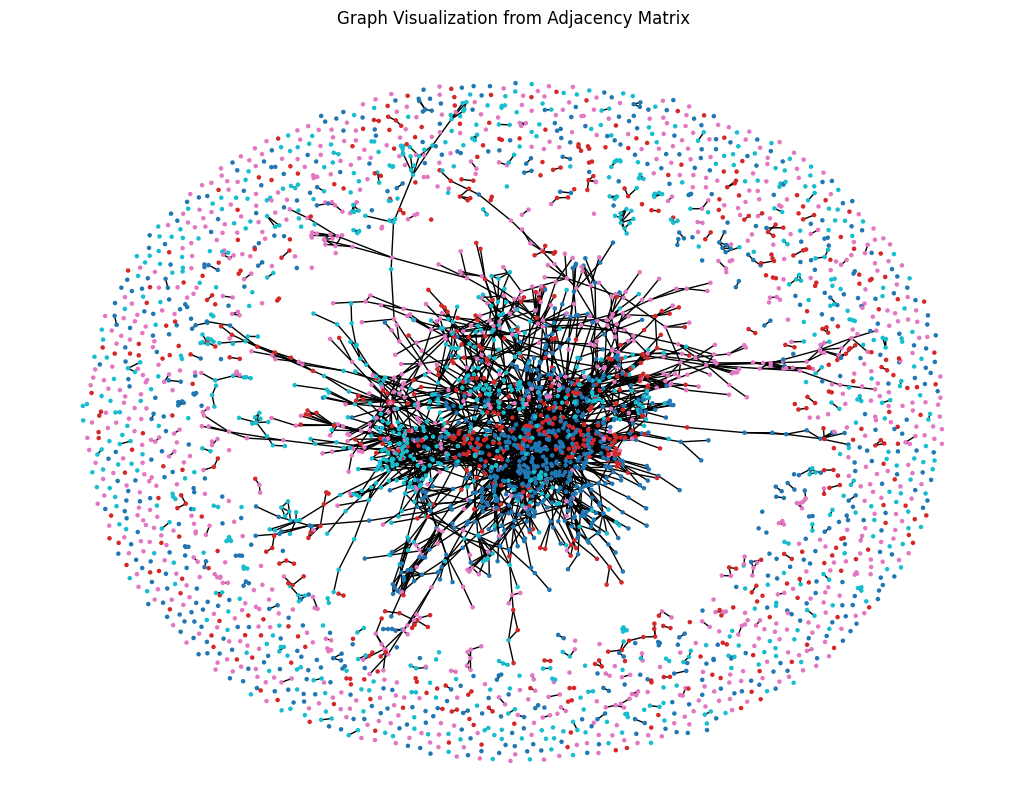

In [17]:
# Create a graph object from the adjacency matrix
# For an undirected graph, use nx.Graph()
# For a directed graph, use nx.DiGraph()
G = nx.from_numpy_array(data_adj)

# Generate node colors from labels
# If labels are integers or categorical, map them to a colormap
unique_labels = np.unique(labels)
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # you can change 'tab10' to 'viridis', 'plasma', etc.
node_colors = [color_map(label) for label in labels]
# 3. Visualize the graph
# nx.draw_networkx provides a good default visualization
# You can customize node colors, labels, edge styles, etc.
plt.figure(figsize=(13, 10)) # Adjust figure size as needed
nx.draw_networkx(G, with_labels=False,node_color=node_colors, node_size=5)

# 4. Display the plot
plt.title("Graph Visualization from Adjacency Matrix")
plt.axis('off') # Hide the axes
plt.show()

In [2]:
name = 'dblp'
n_clusters = 4
# n_z=20
n_input = 50
alpha_value = 0.2
lambda_value = 10
gamma_value = 1e3
lr = 1e-4

In [101]:
# data pre-precessing: X, y, A, A_norm, Ad
X, y, A = load_graph_data(name, show_details=True)

++++++++++++++++++++++++++++++
---details of graph dataset---
++++++++++++++++++++++++++++++
dataset name:    dblp
feature shape:   (4057, 334)
label shape:     (4057,)
adj shape:       (4057, 4057)
undirected edge num:    3528
category num:           4
category distribution: 
label 0:1197
label 1:745
label 2:1109
label 3:1006
++++++++++++++++++++++++++++++


In [102]:
X

array([[-0.53840993,  0.17483684, -0.23398125, ..., -0.23694221,
         0.0421888 ,  0.06917074],
       [-0.20351169, -0.25457241,  0.61896537, ...,  0.06598992,
         0.11876987, -0.1447607 ],
       [ 0.16975411,  0.1548366 ,  0.88862491, ...,  0.40026929,
        -0.12165842, -0.14186343],
       ...,
       [-0.42846774, -0.20133055,  1.02776372, ...,  0.08034791,
         0.00769528, -0.02709503],
       [ 0.38449161, -0.75147906,  1.17324948, ..., -0.04896479,
        -0.14923112,  0.48356746],
       [-0.61994493,  0.11057466,  0.16733029, ...,  0.09364586,
         0.04727523, -0.09361634]], shape=(4057, 50))

In [103]:
print(device)

cpu


In [104]:
print(torch.__version__)
print(torch.version.cuda)   # None means CPU-only build
print(torch.cuda.is_available())

2.8.0+cpu
None
False


In [105]:
A_norm = normalize_adj(A, self_loop=True, symmetry=False)

In [106]:
Ad = diffusion_adj(A, mode="ppr", transport_rate=alpha_value)

# to torch tensor
X = numpy_to_torch(X).to(device)
A_norm = numpy_to_torch(A_norm, sparse=True).to(device)
Ad = numpy_to_torch(Ad).to(device)

In [107]:
# Dual Correlation Reduction Network
model = DCRN(n_node=X.shape[0]).to(device)

In [108]:
# deep graph clustering
acc, nmi, ari, f1 = train(model, X, y, A, A_norm, Ad)
print("ACC: {:.4f},".format(acc), "NMI: {:.4f},".format(nmi), "ARI: {:.4f},".format(ari), "F1: {:.4f}".format(f1))

Training…


  0%|          | 0/400 [00:00<?, ?it/s]

ACC: 0.4545, NMI: 0.1222, ARI: 0.1283, F1: 0.4236


## 2) ACM

In [13]:
data_adj = np.load('./datasets/existing_data/acm/acm_adj.npy')
labels = np.load('./datasets/existing_data/acm/acm_label.npy')

C:\Users\decis\AppData\Local\Temp\ipykernel_12240\3644313950.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # you can change 'tab10' to 'viridis', 'plasma', etc.


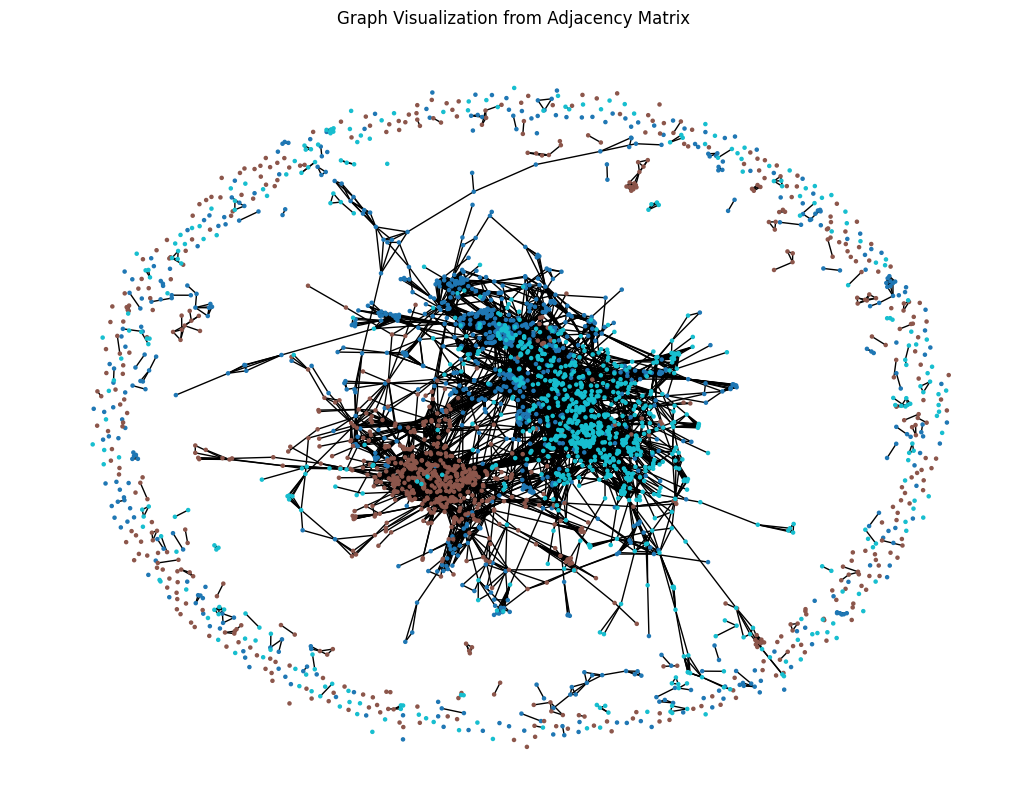

In [15]:
# Create a graph object from the adjacency matrix
# For an undirected graph, use nx.Graph()
# For a directed graph, use nx.DiGraph()
G = nx.from_numpy_array(data_adj)

# Generate node colors from labels
# If labels are integers or categorical, map them to a colormap
unique_labels = np.unique(labels)
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # you can change 'tab10' to 'viridis', 'plasma', etc.
node_colors = [color_map(label) for label in labels]
# 3. Visualize the graph
# nx.draw_networkx provides a good default visualization
# You can customize node colors, labels, edge styles, etc.
plt.figure(figsize=(13, 10)) # Adjust figure size as needed
nx.draw_networkx(G, with_labels=False,node_color=node_colors, node_size=5)

# 4. Display the plot
plt.title("Graph Visualization from Adjacency Matrix")
plt.axis('off') # Hide the axes
plt.show()

In [109]:
name = 'acm'
n_clusters = 3
n_input = 100
alpha_value = 0.2
lambda_value = 10
gamma_value = 1e3
lr = 5e-5

In [110]:
# data pre-precessing: X, y, A, A_norm, Ad
X, y, A = load_graph_data(name, show_details=True)
A_norm = normalize_adj(A, self_loop=True, symmetry=False)
Ad = diffusion_adj(A, mode="ppr", transport_rate=alpha_value)

# to torch tensor
X = numpy_to_torch(X).to(device)
A_norm = numpy_to_torch(A_norm, sparse=True).to(device)
Ad = numpy_to_torch(Ad).to(device)

++++++++++++++++++++++++++++++
---details of graph dataset---
++++++++++++++++++++++++++++++
dataset name:    acm
feature shape:   (3025, 1870)
label shape:     (3025,)
adj shape:       (3025, 3025)
undirected edge num:    13128
category num:           3
category distribution: 
label 0:1061
label 1:965
label 2:999
++++++++++++++++++++++++++++++


In [111]:
# Dual Correlation Reduction Network
model = DCRN(n_node=X.shape[0]).to(device)

In [112]:
# deep graph clustering
acc, nmi, ari, f1 = train(model, X, y, A, A_norm, Ad)
print("ACC: {:.4f},".format(acc), "NMI: {:.4f},".format(nmi), "ARI: {:.4f},".format(ari), "F1: {:.4f}".format(f1))

Training…


  0%|          | 0/400 [00:00<?, ?it/s]

ACC: 0.8420, NMI: 0.5738, ARI: 0.6002, F1: 0.8413


# Existing dataset not in the original paper

## AMAC

In [8]:
name = 'amac'
n_clusters = 10
n_input = 50
alpha_value = 0.2
lambda_value = 10
gamma_value = 1e3
lr = 5e-5

In [9]:
# data pre-precessing: X, y, A, A_norm, Ad
X, y, A = load_graph_data(name, show_details=True)
A_norm = normalize_adj(A, self_loop=True, symmetry=False)
Ad = diffusion_adj(A, mode="ppr", transport_rate=alpha_value)

# to torch tensor
X = numpy_to_torch(X).to(device)
A_norm = numpy_to_torch(A_norm, sparse=True).to(device)
Ad = numpy_to_torch(Ad).to(device)

++++++++++++++++++++++++++++++
---details of graph dataset---
++++++++++++++++++++++++++++++
dataset name:    amac
feature shape:   (13752, 767)
label shape:     (13752,)
adj shape:       (13752, 13752)
undirected edge num:    80062
category num:           10
category distribution: 
label 0:436
label 1:2142
label 2:1414
label 3:542
label 4:5158
label 5:308
label 6:487
label 7:818
label 8:2156
label 9:291
++++++++++++++++++++++++++++++


In [10]:
# Dual Correlation Reduction Network
model = DCRN(n_node=X.shape[0]).to(device)

In [11]:
# deep graph clustering
acc, nmi, ari, f1 = train(model, X, y, A, A_norm, Ad)
print("ACC: {:.4f},".format(acc), "NMI: {:.4f},".format(nmi), "ARI: {:.4f},".format(ari), "F1: {:.4f}".format(f1))

Training…


  0%|          | 0/400 [00:00<?, ?it/s]

ACC: 0.3527, NMI: 0.3175, ARI: 0.1940, F1: 0.3136


# Scraped Data

In [13]:
import numpy as np

In [14]:
data = np.load('./datasets/existing_data/linkedin/linkedin_label.npy')

In [15]:
np.unique(data)

array([0, 1])

In [16]:
data

array([0, 0, 0, ..., 0, 0, 0], shape=(3661,))

In [40]:
data_features = np.load('./datasets/existing_data/linkedin/linkedin_feat.npy')

In [41]:
np.unique(data_features)

array([0., 1.])

In [42]:
data_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], shape=(4057, 334))

In [20]:
data_adj = np.load('./datasets/existing_data/linkedin/linkedin_adj.npy')

In [21]:
data_adj

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(3661, 3661))

In [22]:
np.unique(data_adj)

array([0., 1.])

# training of our model and getting results

In [113]:
name = 'linkedin'
n_clusters = 2
n_input = 10
alpha_value = 0.2
lambda_value = 10
gamma_value = 1e3
lr = 1e-4

In [114]:
# data pre-precessing: X, y, A, A_norm, Ad
X, y, A = load_graph_data(name, show_details=True)
A_norm = normalize_adj(A, self_loop=True, symmetry=False)
Ad = diffusion_adj(A, mode="ppr", transport_rate=alpha_value)

# to torch tensor
X = numpy_to_torch(X).to(device)
A_norm = numpy_to_torch(A_norm, sparse=True).to(device)
Ad = numpy_to_torch(Ad).to(device)

++++++++++++++++++++++++++++++
---details of graph dataset---
++++++++++++++++++++++++++++++
dataset name:    linkedin
feature shape:   (3661, 12)
label shape:     (3661,)
adj shape:       (3661, 3661)
undirected edge num:    3753
category num:           2
category distribution: 
label 0:3620
label 1:41
++++++++++++++++++++++++++++++


In [115]:
# Dual Correlation Reduction Network
model = DCRN(n_node=X.shape[0]).to(device)

In [116]:
# deep graph clustering
acc, nmi, ari, f1 = train(model, X, y, A, A_norm, Ad)
print("ACC: {:.4f},".format(acc), "NMI: {:.4f},".format(nmi), "ARI: {:.4f},".format(ari), "F1: {:.4f}".format(f1))

Training…


  0%|          | 0/400 [00:00<?, ?it/s]

ACC: 0.5209, NMI: 0.0050, ARI: -0.0012, F1: 0.3466
